Here, we want to make a script which calculates the number of sites and % that fall in introns, exons, intergenic regions, and genic regions. I will use the gff file provided, writing data to pandas.

In [1]:
import rnaseqpoptools as rnaseqpop

In [2]:
%matplotlib inline
import pandas as pd
import allel
import numpy as np

In [3]:
# Read in parameters from snakemake
dataset = "Busia"
metadata = pd.read_csv("../../config/samples.tsv", sep="\t")
metadata = metadata.sort_values(by='species')
chroms = ['2L', '2R', '3R', '3L', 'X']
ploidy = 10 
numbers = rnaseqpop.get_numbers_dict(ploidy)
qualflt = 30
missingprop = 1
gffpath = "../../resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3"

In [14]:
snp_di = {}

for chrom in chroms:

    # Read in and Filter VCF
    path = f"../../results/variantAnalysis/vcfs/Ag_Busia.{chrom}.vcf.gz"
    vcf, geno, acsubpops, pos, depth, snpeff, subpops, populations = rnaseqpop.readAndFilterVcf(path=path,
                                                           chrom=chrom,
                                                           samples=metadata,
                                                           numbers=numbers,
                                                           ploidy=ploidy,
                                                           qualflt=qualflt,
                                                           missingfltprop=missingprop)
    
    gff3 = allel.gff3_to_dataframe(gffpath, attributes=['ID', 'Parent']).query("seqid == @chrom & type == 'gene'")
    starts = gff3.loc[:, 'start'].to_list()
    stops = gff3.loc[:, 'end'].to_list()
    pos_bool = pos.locate_intersection_ranges(starts, stops)[0]  
    snpeff = snpeff[pos_bool]
    
    snp_di[chrom] = snpeff


-------------- Reading VCF for chromosome 2L --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 1 -------
QUAL filter will retain 322603 SNPs retained out of 396426 for chromosome 2L
Missingness filter will retain 215513 SNPs out of 396426 for chromosome 2L
The combined filter will retain 165136 SNPs out of 396426 for chromosome 2L

-------------- Reading VCF for chromosome 2R --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 1 -------
QUAL filter will retain 437795 SNPs retained out of 533960 for chromosome 2R
Missingness filter will retain 313151 SNPs out of 533960 for chromosome 2R
The combined filter will retain 239861 SNPs out of 533960 for chromosome 2R

-------------- Reading VCF for chromosome 3R --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 1 -------
QUAL filter will retain 314136 SNPs retained out of 381788 for chromosome 3R
Missingness filter will retain 215018 SNPs out of 381788 for chro

In [15]:
snpeff = pd.concat(snp_di)

In [16]:
snpeff[7].value_counts()

protein_coding    607599
                   15943
miRNA                623
snoRNA               201
pseudogene           146
snRNA                125
misc_RNA              86
rRNA                  46
Name: 7, dtype: int64

In [20]:
snpeff = snpeff[snpeff.iloc[:,1] != 'upstream_gene_variant']
snpeff = snpeff[snpeff.iloc[:,1] != 'downstream_gene_variant']

In [21]:
snpeff[snpeff.iloc[:, 7] == 'protein_coding'].iloc[:,1].value_counts(normalize=True)[:20]

synonymous_variant                                0.580794
missense_variant                                  0.164035
3_prime_UTR_variant                               0.089646
intron_variant                                    0.089372
5_prime_UTR_variant                               0.051386
5_prime_UTR_premature_start_codon_gain_variant    0.006948
splice_region_variant&synonymous_variant          0.004805
splice_region_variant&intron_variant              0.003248
missense_variant&splice_region_variant            0.001933
frameshift_variant                                0.001391
splice_region_variant                             0.001209
stop_gained                                       0.000630
disruptive_inframe_deletion                       0.000473
conservative_inframe_deletion                     0.000415
conservative_inframe_insertion                    0.000413
splice_donor_variant&intron_variant               0.000328
splice_acceptor_variant&intron_variant            0.0003

In [7]:
snpeff.iloc[:,1].value_counts(normalize=True)[:20]

synonymous_variant                                0.458141
missense_variant                                  0.129076
downstream_gene_variant                           0.126338
upstream_gene_variant                             0.120580
3_prime_UTR_variant                               0.070272
5_prime_UTR_variant                               0.040252
intergenic_region                                 0.026323
intron_variant                                    0.011377
5_prime_UTR_premature_start_codon_gain_variant    0.005430
splice_region_variant&synonymous_variant          0.003788
missense_variant&splice_region_variant            0.001521
frameshift_variant                                0.001091
splice_region_variant                             0.000946
splice_region_variant&intron_variant              0.000889
stop_gained                                       0.000494
disruptive_inframe_deletion                       0.000374
conservative_inframe_insertion                    0.0003

### PCA no labels

Performing PCA on Busia chromosome X
iteration 1 retaining 11916 removing 57780 variants


FileNotFoundError: [Errno 2] No such file or directory: 'results/variantAnalysis/pca/PCA-X-Busia.png'

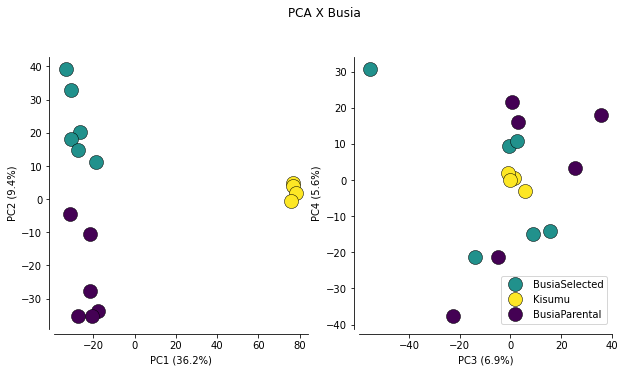

In [10]:
#### Principal Components Analysis (PCA) ####
# Set up dict to store indices for colours
d={}
for name, inds in subpops.items():
    for n in range(len(inds)):
        p = inds[n]
        d[p] = name

# Store dict as a dataframe and get colours 
treatment_indices = pd.DataFrame.from_dict(d, orient='index').reset_index()
treatment_indices = treatment_indices.rename(columns = {'index':'sample_index', 0:"name"})
pop_colours = get_colour_dict(treatment_indices['name'], "viridis")

# Run PCA function defined in tools.py
print(f"Performing PCA on {dataset} chromosome {chrom}")
pca(geno, chrom, ploidy, dataset, populations, metadata, pop_colours, prune=True, scaler=None)

### We want to find intergenic and intron sequence

intergenic = complement of genic     

intronic = complement of intergenic, and exonic?

In [11]:
def getSNPGffstats(gff, pos):
    """
    Calculates number of sites found that intersect with a GFF feature and the proportion % 
    """
    
    refBases = allel.SortedIndex(np.arange(1, gff['end'].max()+1))

    exons = gff.query("type == 'exon'")
    genes = gff.query("type == 'gene'")
    
    ## Get intergenic and intronic SNP numbers
    snpsInGenesBool = pos.locate_intersection_ranges(genes['start'], genes['end'])[0] # Locate genic snps
    intergenicSNPs = pos[~snpsInGenesBool]                 # get complement of genic snps - intergenic
    genicSNPs = pos[snpsInGenesBool]             
    snpsInExonsBool = genicSNPs.locate_intersection_ranges(exons['start'], exons['end'])[0]
    exonicSNPs = genicSNPs[snpsInExonsBool]
    intronicSNPs = genicSNPs[~snpsInExonsBool]

    ## Get intergenic and intronic SNP numbers in Reference genome
    snpsInGenesBool = refBases.locate_intersection_ranges(genes['start'], genes['end'])[0] # Locate genic snps
    RefIntergenicSNPs = refBases[~snpsInGenesBool]                 # get complement of genic snps - intergenic
    RefGenicSNPs = refBases[snpsInGenesBool]             
    snpsInExonsBool = RefGenicSNPs.locate_intersection_ranges(exons['start'], exons['end'])[0]
    RefExonicSNPs = RefGenicSNPs[snpsInExonsBool]
    RefIntronicSNPs = RefGenicSNPs[~snpsInExonsBool]
    
    RefDict = {}
    SamplesDict = {}
    for feature in ['chromosome', 'gene', 'exon', 'intron', 'three_prime_UTR', 'five_prime_UTR']:
                RefDict[feature] = getSNPsinType(gff, refBases, feature, verbose=False)
                SamplesDict[feature] = getSNPsinType(gff, pos, feature, verbose=False)
    
    RefDict['intergenic'] = [RefIntergenicSNPs.shape[0], refBases.shape[0], RefIntergenicSNPs.shape[0]/refBases.shape[0]]
    SamplesDict['intergenic'] = [intergenicSNPs.shape[0], pos.shape[0], intergenicSNPs.shape[0]/pos.shape[0]]
    RefDict['intron'] = [RefIntronicSNPs.shape[0], refBases.shape[0], RefIntronicSNPs.shape[0]/refBases.shape[0]]
    SamplesDict['intron'] = [intronicSNPs.shape[0], pos.shape[0], intronicSNPs.shape[0]/pos.shape[0]]
    
    ref = pd.DataFrame.from_dict(RefDict).T.rename(columns={2:'ReferenceGenomeProportion'})[['ReferenceGenomeProportion']]
    res = pd.DataFrame.from_dict(SamplesDict).T.rename(columns={0:'called', 1:'total', 2:'proportion'})
    res[['total', 'called']] = res[['total', 'called']].astype(int)
    ref = ref.merge(res, left_index=True, right_index=True)
    return(ref)


def getSNPsinType(gff, pos, feature, verbose=False):
    gf = gff.query("type == @feature")

    snps = pos.intersect_ranges(gf['start'], gf['end'])
    total = pos.shape[0]
    called = snps.shape[0]
    prop = called/total
    return(called, total, prop)

In [13]:
gff = allel.gff3_to_dataframe(gffpath, attributes=['Parent', 'ID'])
gff = gff.query("seqid == @chrom")

In [14]:
df = getSNPGffstats(gff, pos)
df.round(3)

,ReferenceGenomeProportion,called,total,proportion
chromosome,1.000,51496,51496,1.000
gene,0.444,38891,51496,0.755
exon,0.134,29648,51496,0.576
intron,0.311,9267,51496,0.180
three_prime_UTR,0.035,11748,51496,0.228
five_prime_UTR,0.018,4292,51496,0.083
intergenic,0.556,12605,51496,0.245


In [16]:
df = pd.read_csv("../../results/variantAnalysis/SNPstats/snpsPerGenomicFeature.tsv", sep="\t")
df = df.rename(columns={'feature': 'type'}).set_index("type")

In [17]:
df = df[['ReferenceGenomeProportion', 'proportion']]
df = df.reset_index().rename(columns={'index': 'type'}).query("type not in ['chromosome', 'gene']").set_index("type")

In [18]:
df = df.sort_values(by='proportion', ascending=False).reset_index().rename(columns={'index':'type'})
df = df.rename(columns={'ReferenceGenomeProportion': 'AgamP4 reference', 'proportion': 'Dataset SNPs'})
df = df.melt(id_vars=['type'], value_vars=['AgamP4 reference', 'Dataset SNPs'], var_name="data", value_name="prop")

In [19]:
df

,type,data,prop
0,exon,AgamP4 reference,0.141347
1,three_prime_UTR,AgamP4 reference,0.031680
2,intergenic,AgamP4 reference,0.537352
3,intron,AgamP4 reference,0.321513
4,five_prime_UTR,AgamP4 reference,0.016448
5,exon,Dataset SNPs,0.726647
6,three_prime_UTR,Dataset SNPs,0.202863
7,intergenic,Dataset SNPs,0.160186
8,intron,Dataset SNPs,0.113298
9,five_prime_UTR,Dataset SNPs,0.082495


In [20]:
exon = df.query("type == 'exon'")
intergenic = df.query("type == 'intergenic'")
intron = df.query("type == 'intron'")
threeprime = df.query("type == 'three_prime_UTR'")
fiveprime = df.query("type == 'five_prime_UTR'")

In [21]:
intergenic.loc[:,'prop'] = 1
fullexon= (exon['prop'].reset_index(drop=True)).to_list()
exon.loc[:,'prop'] = (exon['prop'].reset_index(drop=True) - threeprime['prop'].reset_index(drop=True)).to_list()
threeprime.loc[:,'prop'] = (fullexon + intron['prop']).reset_index(drop=True).to_list()
intron.loc[:,'prop'] = (intron['prop'].reset_index(drop=True) + exon['prop'].reset_index(drop=True)).to_list()

/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
threeprime

,type,data,prop
1,three_prime_UTR,AgamP4 reference,0.462860
6,three_prime_UTR,Dataset SNPs,0.839944


In [23]:
exon

,type,data,prop
0,exon,AgamP4 reference,0.109666
5,exon,Dataset SNPs,0.523784


In [24]:
fullexon

[0.14134655542974695, 0.7266468411707674]

In [25]:
intron

,type,data,prop
3,intron,AgamP4 reference,0.431179
8,intron,Dataset SNPs,0.637082


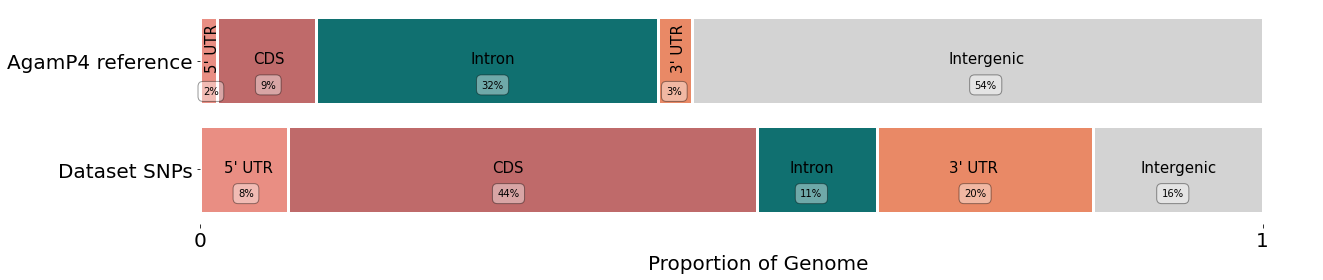

In [32]:
plt.figure(figsize=[20,4])
ax = plt.gca()
plot1 = sns.barplot(data=intergenic, x='prop', y='data', color="lightgrey", edgecolor='white', linewidth=3)
plot3 = sns.barplot(data=threeprime, x='prop', y='data', color="coral",edgecolor='white', linewidth=3)
plot2 = sns.barplot(data=intron , x='prop', y='data', color="teal" , edgecolor='white', linewidth=3)
plot4 = sns.barplot(data=exon, x='prop', y='data', color="indianred", edgecolor='white', linewidth=3)
plot5 = sns.barplot(data=fiveprime, x='prop', y='data', color="salmon",  edgecolor='white', linewidth=3)
#plt.ylabel("Data", fontdict={'fontsize': 20})
plt.ylabel(None)
plt.xlabel("Proportion of Genome", fontdict={'fontsize': 20})
plt.xticks([0,1], fontsize=20)
plt.yticks(fontsize=20)


# Using Matplotlib's annotate function and
# passing the coordinates where the annotation shall be done
# x-coordinate: bar.get_x() + bar.get_width() / 2
# y-coordinate: bar.get_height()
# free space to be left to make graph pleasing: (0, 8)
# ha and va stand for the horizontal and vertical alignment
plot1.annotate( "5' UTR", xy=(0.018,1.10),
               size=15, xytext=(5, 8),
               textcoords='offset points')
plot1.annotate( "5' UTR", xy=(0,0.15), rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')

plot1.annotate( "CDS", xy=(0.045,0.10),# rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')
plot1.annotate( "CDS", xy=(0.27,1.10), #rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')
    
    
plot1.annotate( "3' UTR", xy=(0.439,0.15), rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')
plot1.annotate( "3' UTR", xy=(0.70,1.10),# rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')

    
plot1.annotate( "Intron", xy=(0.25,0.10),# rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')
plot1.annotate( "Intron", xy=(0.55,1.10),# rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')


plot1.annotate( "Intergenic", xy=(0.70,0.10),# rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')
plot1.annotate( "Intergenic", xy=(0.88,1.10),# rotation=90,
               size=15, xytext=(5, 8),
               textcoords='offset points')

#cds ref
ax.text(0.057, 0.25, "9%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))
#int data
ax.text(0.905,1.25, "16%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))
#int ref
ax.text(0.729, 0.25, "54%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))
# intron ref
ax.text(0.265, 0.25, "32%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))
# intron d
ax.text(0.565, 1.25, "11%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))

# cds
ax.text(0.280, 1.25, "44%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))

# 3utr
ax.text(0.719, 1.25, "20%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))

# 5utr data
ax.text(0.036, 1.25, "8%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))

# 5utr ref
ax.text(0.003, 0.31, "2%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))

# 3utr ref
ax.text(0.439, 0.31, "3%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))
sns.despine(bottom = True, left = True)

plt.savefig("../../results/variantAnalysis/SNPstats/barPlot.fractions.pdf", bbox_inches='tight', dpi=500)
plt.show()

In [96]:
df.groupby('data').agg({'prop':'sum'})

,prop
data,
AgamP4 reference,1.048340
Dataset SNPs,1.285488
